In [120]:
import numpy as np
import networkx as nx
import copy
import matplotlib.pyplot as plt

class adjmatrix:
    def __init__(self):
        # initialize a 1000x1000 matrix *mainly distance
        size = 10
        
        #edges
        self.matrix = np.zeros(shape=(size,size))
        self.edge_uv = np.array([[np.nan,np.nan,np.nan,np.nan]]) #np.empty(shape=[0, 4])
        
        #nodes
        self.nodedata = np.array([[0,0,0,0]]) # x,y,theta,z, includes features and poses (MEASURED)
        self.node = np.array([0]) # +1 for pose, -1 for landmarks, max is pose, min is landmarks
        
        self.X = np.array([[0,0,0,0]])
        
        self.cost = []
        
    # U is the pose to pose measurements
    def posetopose(self, uX, uY, uO, uZ):
        
        lastpose = max(self.node)
        ind, = np.where(self.node == lastpose)
        index_lastpose = ind[0]
        
        u = np.array([uX, uY, uO, uZ])
        
        #1 add a new node (pose) 
        node_type = max(self.node)+1  #pose index max + 1
        self.node = np.append(self.node, node_type)
        self.nodedata = np.append(self.nodedata, [self.nodedata[index_lastpose] + u], axis = 0) #measured node = U + previous node

        #2 add a new edge
        self.edge_uv = np.append(self.edge_uv, [u], axis = 0) #append u
        index_lastedge = len(self.edge_uv)-1
        self.matrix[index_lastpose][len(self.node)-1] = index_lastedge  #pose to newest node

    def posetonewfeat(self, vX, vY, vO, vZ):
        
        lastpose = max(self.node)
        ind, = np.where(self.node == lastpose)
        index_lastpose = ind[0]
        
        v = np.array([vX, vY, vO, vZ])
        
        #1 add a new node (feature)
        node_type =  min(self.node)-1 #pose index max + 1
        self.node = np.append(self.node, node_type)
        self.nodedata = np.append(self.nodedata, [self.nodedata[index_lastpose] + v], axis = 0) #measured node = U + previous node
        
        
        #2 add a new edge
        self.edge_uv = np.append(self.edge_uv, [v], axis = 0) #append u
        index_newedge = len(self.edge_uv)-1
        self.matrix[index_lastpose][len(self.node)-1] = index_newedge  #pose to newest node
        
    def posetooldfeat(self,vX, vY, vO, vZ, feat):
        
        lastpose = max(self.node)
        ind, = np.where(self.node == lastpose)
        index_lastpose = ind[0]
        
        v = np.array([vX, vY, vO, vZ])
        
        #1 add a new node (feature)
        #dont do anything
        
        #2 add a new edge
        self.edge_uv = np.append(self.edge_uv, [v], axis = 0) #append u
        index_newedge = len(self.edge_uv)-1 #index of new edge
        
        feat_index = np.where(self.node == feat)
        
        self.matrix[index_lastpose][feat_index] = index_newedge  #pose to newest node

    
    def getcost(self, nodedata):
        x = np.where(self.matrix != 0)
        edges = np.asarray(x).T
        cost = 0
        for edge in edges:
            node_1 = nodedata[edge[1]]
            node_2 = nodedata[edge[0]]
            meas = self.edge_uv[int(self.matrix[edge[0]][edge[1]])]
            #print(node_1,node_2,meas)
            
            error = (node_1 - node_2 - meas)**2
            cost = cost + np.linalg.norm(error)
        #print ("cost",cost)
        return cost
        
    def getgradient(self,state):
        
        ind = []
        outd = []
        factor = []
        for i in range(len(self.node)):
            in_d = np.count_nonzero(self.matrix[:, i])
            out_d = np.count_nonzero(self.matrix[i, :])
            ind.append(in_d)
            outd.append(out_d)
            factor.append(-2*(out_d-in_d))
        print("in", ind)
        print("out", outd)
        print("factor", factor)
        print("\n")
        
        return factor
    
    
    def graph_posegraph(self,nodedata,i):
        
        if nodedata == []:
            nodedata = self.nodedata
        
        amat = self.matrix
        g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
        g.remove_nodes_from(list(nx.isolates(g)))
        
        #relabelling
        mapping = dict(zip(g, self.node))
        g = nx.relabel_nodes(g, mapping)
        
        #colourmap
        color_map = []
        for node in g.nodes:
            if node < 0:
                color_map.append('red')
            else: 
                color_map.append('white')      
                
        #layout
        layout = nx.spectral_layout(g)
        #layout = nx.spring_layout(g)
        
        #position
        position = copy.deepcopy(nodedata)
        ps = []
        for pos in position:
            ps.append(pos[:2])
        
        z = zip(self.node, ps)
        dic = dict(z)
        
        fig, ax = plt.subplots()
        
        nx.draw_networkx(g, pos=dic, node_color= color_map, with_labels = True)
        nx.draw_networkx_labels(g, pos=dic)
        plt.axis("on")
        ax.set_xlim(-1, 8)
        ax.set_ylim(-1,8)
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        
        plt.savefig("pose/{}.jpg".format(i))
        plt.show()
        #print (amat)
        
        
    def gd(self, iterations, learning_rate, stopping_threshold):
        
        currentstate = self.nodedata
        print("original")
        print(currentstate)
        
        factor = np.array(self.getgradient(currentstate))
        
        
        #copy to new
        newstate = copy.deepcopy(currentstate)
        previouscost = self.getcost(newstate)

        #learn
        for i in range(iterations):#
            
            if previouscost == 0: #perfect calculations
                break
            
            #print nodes update
            if (i % 1 == 0):
                print(i)
                print(newstate)
                self.graph_posegraph(newstate,i)
                
            
            #get gradient
            gradient = copy.deepcopy(newstate)
            for i in range(gradient.shape[0]):
                gradient[i] = gradient[i]*factor[i]
            #print("gradient\n",gradient)
            
            newstate = newstate + learning_rate*gradient #ONLY UPDATE THE NECCESSARY VARIABLES.
            currentcost = self.getcost(newstate)
            print ("curcost",currentcost)
            self.cost.append(currentcost)
            #print ("prvcost",previouscost)
            
            if currentcost > previouscost:
                break
            
            previouscost = currentcost 
        
        print("converge")
        print(newstate)
    
        
    def graph_location(self, nodedata):
        pose_ind, = np.where(self.node >= 0)
        land_ind, = np.where(self.node < 0)
        print (pose_ind,land_ind)
        #colour identity
    
    def pr(self):
        print ("node (pose/landmark)\n",self.node)
        print ("nodedata (assumed state)\n",self.nodedata)
        print ("edgedata (u/v)\n",self.edge_uv)
        print ("\n")
        print (np.matrix(self.matrix))
        print ()
    
    def prcost(self):
        ite = list(range(0, len(self.cost)))
        cs = self.cost
        plt.plot(ite,cs)
        plt.title('Cost vs Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Costs')
        plt.show()
        print (self.cost)
         

# Intializing Matrix, 
Measured Data (from excel)
Compare with Ground Truth

In [121]:
a = adjmatrix() 
#a.print()
a.posetopose(0,2,0,0) #new pose x,y,o,{z}
#a.print()
a.posetonewfeat(2,2,0,0) #new feat
#a.print()
a.posetopose(0,2,0,0) #new pose
#a.print()
a.posetooldfeat(2,2,0,0,-1) #linked to 2nd landmark
#a.print()
a.posetopose(0,2,0,0) #new pose
#a.pr()

# Visualize PoseGraph

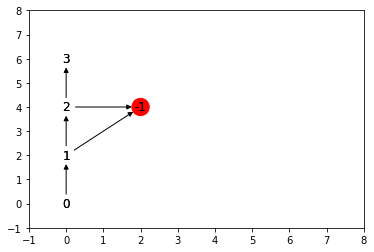

In [123]:
a.graph_posegraph([],0)

# Visualize Gradient Descent

original
[[0 0 0 0]
 [0 2 0 0]
 [2 4 0 0]
 [0 4 0 0]
 [0 6 0 0]]
in [0, 1, 2, 1, 1]
out [1, 2, 0, 2, 0]
factor [-2, -2, 4, -2, 2]


0
[[0 0 0 0]
 [0 2 0 0]
 [2 4 0 0]
 [0 4 0 0]
 [0 6 0 0]]


<ipython-input-120-19f2b36962a2>:117: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if nodedata == []:


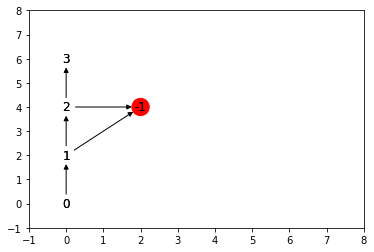

curcost 3.9054130881693503
1
[[0.    0.    0.    0.   ]
 [0.    1.996 0.    0.   ]
 [2.008 4.016 0.    0.   ]
 [0.    3.992 0.    0.   ]
 [0.    6.012 0.    0.   ]]


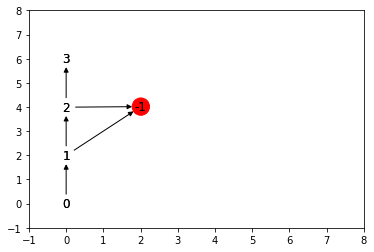

curcost 3.8134699425477305
2
[[0.       0.       0.       0.      ]
 [0.       1.992008 0.       0.      ]
 [2.016032 4.032064 0.       0.      ]
 [0.       3.984016 0.       0.      ]
 [0.       6.024024 0.       0.      ]]


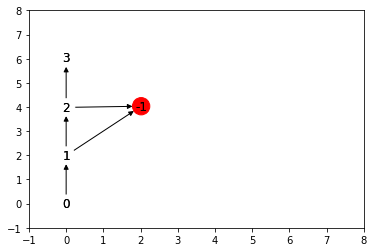

curcost 3.7241839182463594
3
[[0.         0.         0.         0.        ]
 [0.         1.98802398 0.         0.        ]
 [2.02409613 4.04819226 0.         0.        ]
 [0.         3.97604797 0.         0.        ]
 [0.         6.03607205 0.         0.        ]]


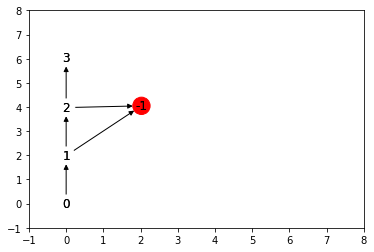

curcost 3.6375685323761595
4
[[0.         0.         0.         0.        ]
 [0.         1.98404794 0.         0.        ]
 [2.03219251 4.06438503 0.         0.        ]
 [0.         3.96809587 0.         0.        ]
 [0.         6.04814419 0.         0.        ]]


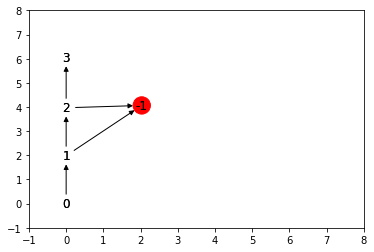

curcost 3.5536374677690024
5
[[0.         0.         0.         0.        ]
 [0.         1.98007984 0.         0.        ]
 [2.04032128 4.08064257 0.         0.        ]
 [0.         3.96015968 0.         0.        ]
 [0.         6.06024048 0.         0.        ]]


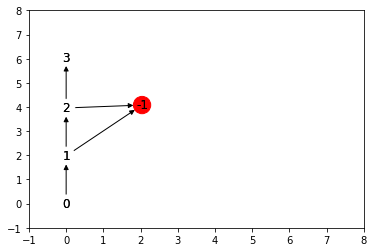

curcost 3.472404577075494
6
[[0.         0.         0.         0.        ]
 [0.         1.97611968 0.         0.        ]
 [2.04848257 4.09696514 0.         0.        ]
 [0.         3.95223936 0.         0.        ]
 [0.         6.07236096 0.         0.        ]]


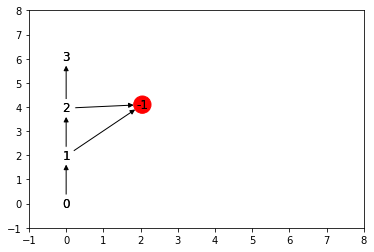

curcost 3.393883887290654
7
[[0.         0.         0.         0.        ]
 [0.         1.97216744 0.         0.        ]
 [2.0566765  4.113353   0.         0.        ]
 [0.         3.94433488 0.         0.        ]
 [0.         6.08450568 0.         0.        ]]


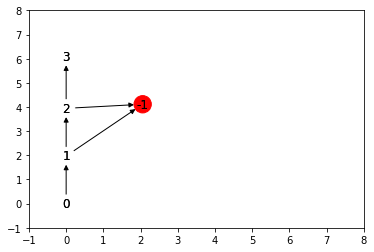

curcost 3.318089604766448
8
[[0.         0.         0.         0.        ]
 [0.         1.96822311 0.         0.        ]
 [2.0649032  4.12980641 0.         0.        ]
 [0.         3.93644621 0.         0.        ]
 [0.         6.09667469 0.         0.        ]]


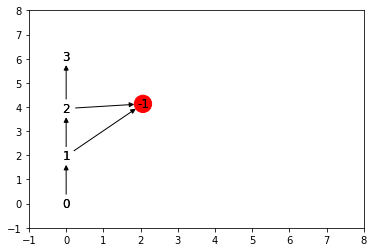

curcost 3.2450361207790617
9
[[0.         0.         0.         0.        ]
 [0.         1.96428666 0.         0.        ]
 [2.07316282 4.14632563 0.         0.        ]
 [0.         3.92857332 0.         0.        ]
 [0.         6.10886804 0.         0.        ]]


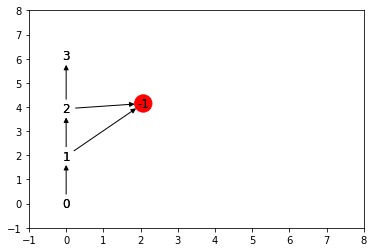

curcost 3.1747380177291693
10
[[0.         0.         0.         0.        ]
 [0.         1.96035809 0.         0.        ]
 [2.08145547 4.16291094 0.         0.        ]
 [0.         3.92071617 0.         0.        ]
 [0.         6.12108578 0.         0.        ]]


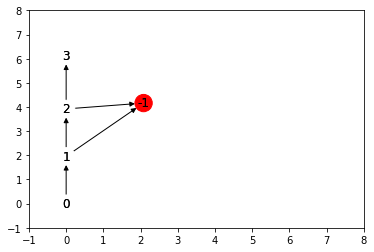

curcost 3.107210076065492
11
[[0.         0.         0.         0.        ]
 [0.         1.95643737 0.         0.        ]
 [2.08978129 4.17956258 0.         0.        ]
 [0.         3.91287474 0.         0.        ]
 [0.         6.13332795 0.         0.        ]]


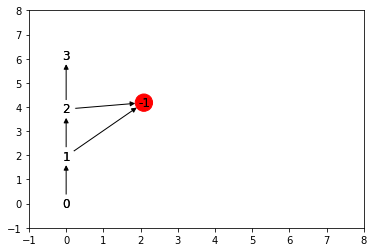

curcost 3.0424672820361165
12
[[0.         0.         0.         0.        ]
 [0.         1.9525245  0.         0.        ]
 [2.09814042 4.19628083 0.         0.        ]
 [0.         3.90504899 0.         0.        ]
 [0.         6.14559461 0.         0.        ]]


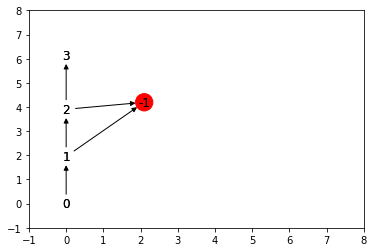

curcost 2.980524836388488
13
[[0.         0.         0.         0.        ]
 [0.         1.94861945 0.         0.        ]
 [2.10653298 4.21306595 0.         0.        ]
 [0.         3.89723889 0.         0.        ]
 [0.         6.1578858  0.         0.        ]]


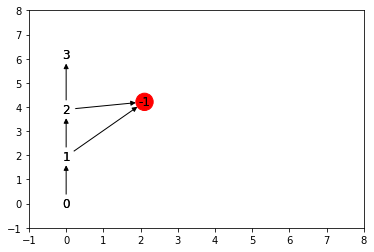

curcost 2.921398164158401
14
[[0.         0.         0.         0.        ]
 [0.         1.94472221 0.         0.        ]
 [2.11495911 4.22991822 0.         0.        ]
 [0.         3.88944442 0.         0.        ]
 [0.         6.17020157 0.         0.        ]]


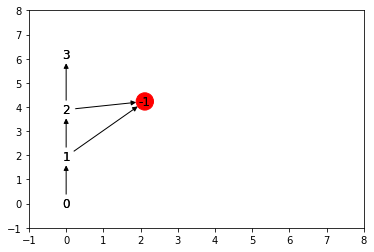

curcost 2.865102925711046
15
[[0.         0.         0.         0.        ]
 [0.         1.94083276 0.         0.        ]
 [2.12341895 4.24683789 0.         0.        ]
 [0.         3.88166553 0.         0.        ]
 [0.         6.18254197 0.         0.        ]]


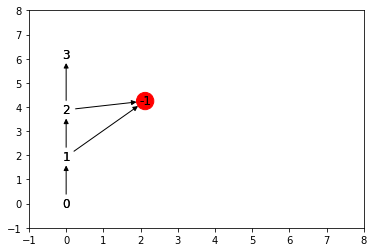

curcost 2.811655029223883
16
[[0.         0.         0.         0.        ]
 [0.         1.9369511  0.         0.        ]
 [2.13191262 4.26382524 0.         0.        ]
 [0.         3.8739022  0.         0.        ]
 [0.         6.19490706 0.         0.        ]]


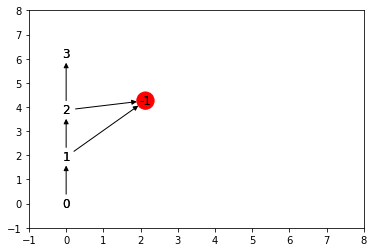

curcost 2.761070644832726
17
[[0.         0.         0.         0.        ]
 [0.         1.9330772  0.         0.        ]
 [2.14044027 4.28088054 0.         0.        ]
 [0.         3.86615439 0.         0.        ]
 [0.         6.20729687 0.         0.        ]]


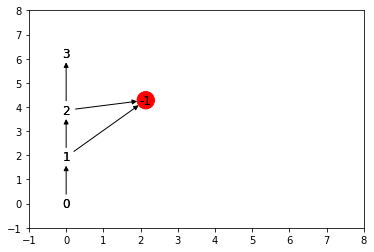

curcost 2.713366220699572
18
[[0.         0.         0.         0.        ]
 [0.         1.92921104 0.         0.        ]
 [2.14900203 4.29800406 0.         0.        ]
 [0.         3.85842208 0.         0.        ]
 [0.         6.21971146 0.         0.        ]]


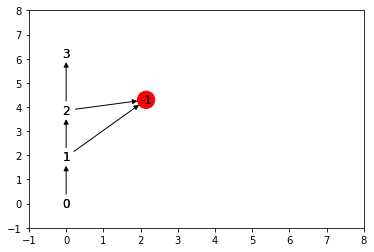

curcost 2.6685585013048905
19
[[0.         0.         0.         0.        ]
 [0.         1.92535262 0.         0.        ]
 [2.15759804 4.31519608 0.         0.        ]
 [0.         3.85070524 0.         0.        ]
 [0.         6.23215089 0.         0.        ]]


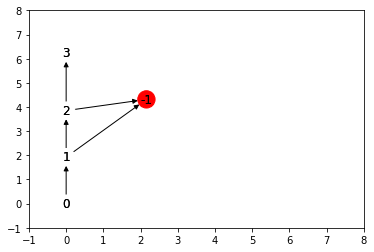

curcost 2.626664548319231
20
[[0.         0.         0.         0.        ]
 [0.         1.92150191 0.         0.        ]
 [2.16622843 4.33245687 0.         0.        ]
 [0.         3.84300383 0.         0.        ]
 [0.         6.24461519 0.         0.        ]]


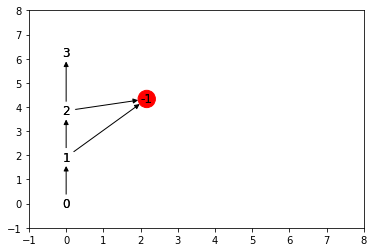

curcost 2.5877017644711207
21
[[0.         0.         0.         0.        ]
 [0.         1.91765891 0.         0.        ]
 [2.17489335 4.34978669 0.         0.        ]
 [0.         3.83531782 0.         0.        ]
 [0.         6.25710442 0.         0.        ]]


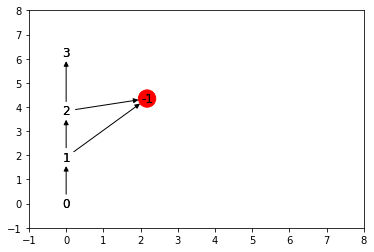

curcost 2.5516879209019807
22
[[0.         0.         0.         0.        ]
 [0.         1.91382359 0.         0.        ]
 [2.18359292 4.36718584 0.         0.        ]
 [0.         3.82764718 0.         0.        ]
 [0.         6.26961863 0.         0.        ]]


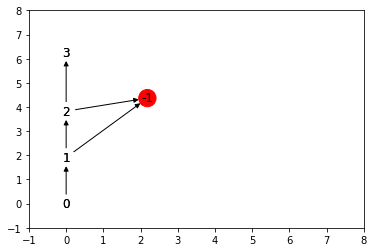

curcost 2.518641188586754
23
[[0.         0.         0.         0.        ]
 [0.         1.90999595 0.         0.        ]
 [2.19232729 4.38465458 0.         0.        ]
 [0.         3.81999189 0.         0.        ]
 [0.         6.28215786 0.         0.        ]]


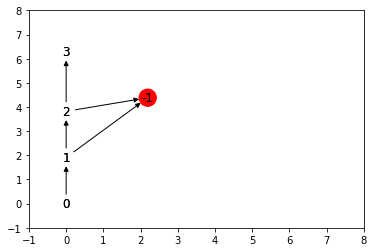

curcost 2.4885801745038827
24
[[0.         0.         0.         0.        ]
 [0.         1.90617595 0.         0.        ]
 [2.2010966  4.4021932  0.         0.        ]
 [0.         3.81235191 0.         0.        ]
 [0.         6.29472218 0.         0.        ]]


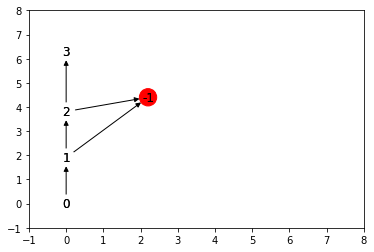

curcost 2.461523963363757
25
[[0.         0.         0.         0.        ]
 [0.         1.9023636  0.         0.        ]
 [2.20990099 4.41980197 0.         0.        ]
 [0.         3.8047272  0.         0.        ]
 [0.         6.30731162 0.         0.        ]]


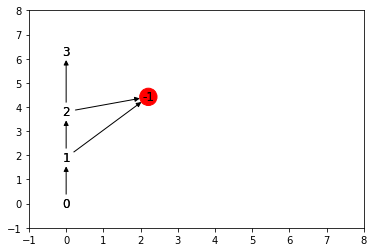

curcost 2.4374921658548527
26
[[0.         0.         0.         0.        ]
 [0.         1.89855887 0.         0.        ]
 [2.21874059 4.43748118 0.         0.        ]
 [0.         3.79711775 0.         0.        ]
 [0.         6.31992625 0.         0.        ]]


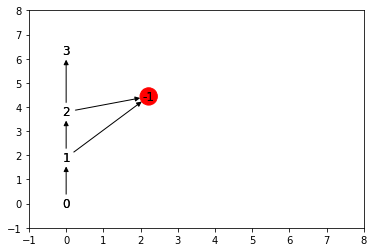

curcost 2.4165049745466662
27
[[0.         0.         0.         0.        ]
 [0.         1.89476176 0.         0.        ]
 [2.22761555 4.45523111 0.         0.        ]
 [0.         3.78952351 0.         0.        ]
 [0.         6.3325661  0.         0.        ]]


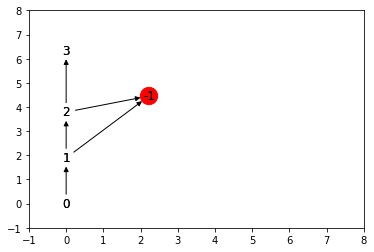

curcost 2.398583228804134
28
[[0.         0.         0.         0.        ]
 [0.         1.89097223 0.         0.        ]
 [2.23652602 4.47305203 0.         0.        ]
 [0.         3.78194447 0.         0.        ]
 [0.         6.34523123 0.         0.        ]]


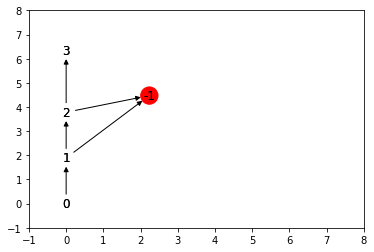

curcost 2.383748490326832
29
[[0.         0.         0.         0.        ]
 [0.         1.88719029 0.         0.        ]
 [2.24547212 4.49094424 0.         0.        ]
 [0.         3.77438058 0.         0.        ]
 [0.         6.3579217  0.         0.        ]]


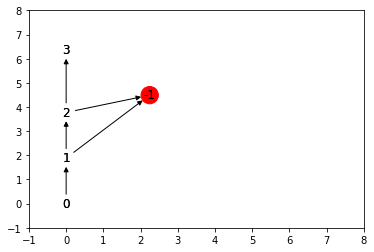

curcost 2.3720231312361872
30
[[0.         0.         0.         0.        ]
 [0.         1.88341591 0.         0.        ]
 [2.25445401 4.50890802 0.         0.        ]
 [0.         3.76683182 0.         0.        ]
 [0.         6.37063754 0.         0.        ]]


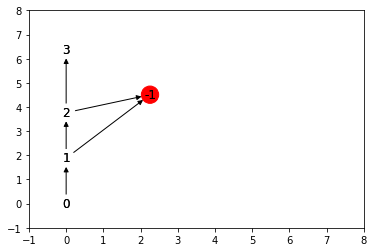

curcost 2.363430437005266
31
[[0.         0.         0.         0.        ]
 [0.         1.87964908 0.         0.        ]
 [2.26347182 4.52694365 0.         0.        ]
 [0.         3.75929815 0.         0.        ]
 [0.         6.38337881 0.         0.        ]]


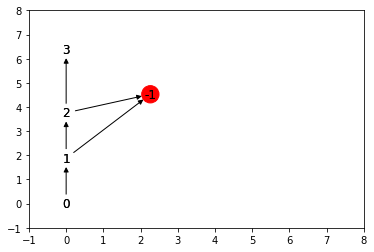

curcost 2.3579947269695536
32
[[0.         0.         0.         0.        ]
 [0.         1.87588978 0.         0.        ]
 [2.27252571 4.54505142 0.         0.        ]
 [0.         3.75177956 0.         0.        ]
 [0.         6.39614557 0.         0.        ]]


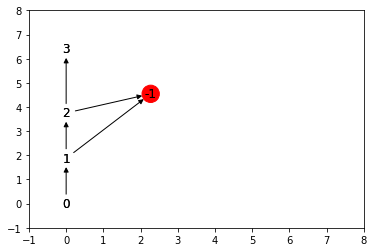

curcost 2.3557414956861944
33
[[0.         0.         0.         0.        ]
 [0.         1.872138   0.         0.        ]
 [2.28161581 4.56323163 0.         0.        ]
 [0.         3.744276   0.         0.        ]
 [0.         6.40893786 0.         0.        ]]


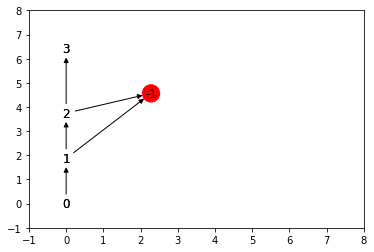

curcost 2.3566975790365783
converge
[[0.         0.         0.         0.        ]
 [0.         1.86839372 0.         0.        ]
 [2.29074228 4.58148456 0.         0.        ]
 [0.         3.73678744 0.         0.        ]
 [0.         6.42175574 0.         0.        ]]


In [124]:
a.gd(iterations = 1000, learning_rate = 0.001, stopping_threshold = 0.1)

In [ ]:
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in ['1.png', '2.png', '3.png', '4.png']:
        image = imageio.imread(filename)
        writer.append_data(image)

# Convergence of Gradient Descent

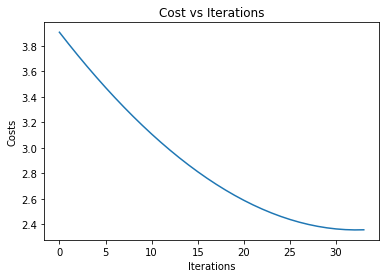

[3.9054130881693503, 3.8134699425477305, 3.7241839182463594, 3.6375685323761595, 3.5536374677690024, 3.472404577075494, 3.393883887290654, 3.318089604766448, 3.2450361207790617, 3.1747380177291693, 3.107210076065492, 3.0424672820361165, 2.980524836388488, 2.921398164158401, 2.865102925711046, 2.811655029223883, 2.761070644832726, 2.713366220699572, 2.6685585013048905, 2.626664548319231, 2.5877017644711207, 2.5516879209019807, 2.518641188586754, 2.4885801745038827, 2.461523963363757, 2.4374921658548527, 2.4165049745466662, 2.398583228804134, 2.383748490326832, 2.3720231312361872, 2.363430437005266, 2.3579947269695536, 2.3557414956861944, 2.3566975790365783]


In [44]:
a.prcost()

# Movement in Pose Graph

# To Do List
1) set up controlled experiment for camera, manually extract following data (pose to pose movement, pose to frame movements, 

1) Experimental Data.
2) Offline Algorithm

initial pose tagged to global frame.